# Estudio descriptivo: cruce con presiones

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Cargamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

/home/dslab/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
os.chdir('..')

In [5]:
# Cargamos las dos tablas de datos
perfiles = pd.read_parquet('data/raw/flex_perfiles_usuario.parquet')
sesiones = pd.read_parquet('data/raw/flex_sesiones.parquet')

In [6]:
# Filtro en perfiles valores erroneos peso y altura. Corrección formatos
perfiles.loc[perfiles["posicion"]=="manual","posicion"] = "Manual"

for col in ["altura", "peso"]:
    perfiles[col] = perfiles[col].str.replace(',', '.')

perfiles[["altura", "peso"]] = perfiles[["altura", "peso"]].apply(pd.to_numeric)

perfiles_filtrado = perfiles[(perfiles["activo"]==1) &(perfiles["peso"]<150) &
                             (perfiles["peso"]!=0 )& (perfiles["altura"]>100) & (perfiles["altura"]<220)]

## Cruce posición sexo

In [7]:
### Cruce posicion sexo
pd.crosstab(perfiles_filtrado["posicion"],perfiles_filtrado["sexo"])
# Los Manual de posicion son exactamente los Manual de sexo

sexo,Female,Male,Manual
posicion,,,
Lateral,752,836,0
Manual,0,0,374
Supine,337,519,0


¿Hay manera de saber qué es Manual en esas dos variables?

## Cruce presiones y sexo

In [8]:
### Cruce presiones y sexo
df_pres_sex = pd.DataFrame(pd.crosstab(perfiles_filtrado["presiones"],perfiles_filtrado["sexo"],normalize=False))
# Elimino aquellas presiones con menos de 10 registros en hombres o mujeres
df_pres_sex = df_pres_sex[(df_pres_sex["Female"]>=10) | (df_pres_sex["Male"]>=10)]
# Vemos las más frecuentes para cada uno
df_pres_sex_fem = df_pres_sex.sort_values(by=['Female'], ascending=False)
df_pres_sex_male = df_pres_sex.sort_values(by=['Male'], ascending=False)

In [10]:
df_pres_sex_fem.head()

sexo,Female,Male,Manual
presiones,,,
112222222222,128,68,0
001122211222,105,0,0
002222112222,66,8,0
002221112222,63,0,0
112222122222,60,1,0


In [11]:
df_pres_sex_male.head()

sexo,Female,Male,Manual
presiones,,,
112233332223,3,77,0
112222322222,2,75,1
112223222222,43,73,0
002233322222,0,70,0
112222222222,128,68,0


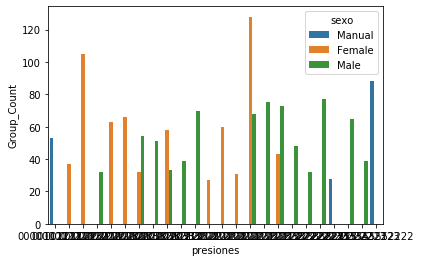

In [12]:
# Para pintarlo
grouped_df = perfiles_filtrado.groupby(["presiones","sexo"])
df_pres_sex_graph = pd.DataFrame(grouped_df.size().reset_index(name = "Group_Count"))
# Elimino aquellas presiones con menos de 20 registros en hombres o mujeres
df_pres_sex_graph = df_pres_sex_graph[df_pres_sex_graph["Group_Count"]>=25]
sns.barplot(y='Group_Count',x='presiones',hue='sexo',data=df_pres_sex_graph)
plt.show()

El gráfico no es muy visual pero permite ver las diferencias con respecto a presiones en hombres y mujeres

## Cruce presiones y posicion

In [13]:
### Cruce presiones y posicion
df_pres_pos = pd.DataFrame(pd.crosstab(perfiles_filtrado["presiones"],perfiles_filtrado["posicion"],normalize=False))
# Elimino aquellas presiones con menos de 10 registros en lateral o supine
df_pres_pos = df_pres_pos[(df_pres_pos["Lateral"]>=10) | (df_pres_pos["Supine"]>=10)]
# Vemos las más frecuentes para cada uno
df_pres_pos_lat = df_pres_pos.sort_values(by=['Lateral'], ascending=False)
df_pres_pos_sup = df_pres_pos.sort_values(by=['Supine'], ascending=False)

In [14]:
df_pres_pos_lat.head()

posicion,Lateral,Manual,Supine
presiones,,,
001122211222,105,0,0
002233211222,91,0,0
002223211222,86,0,0
112233332223,77,0,3
002222112222,74,0,0


df_pres_pos_sup.head()

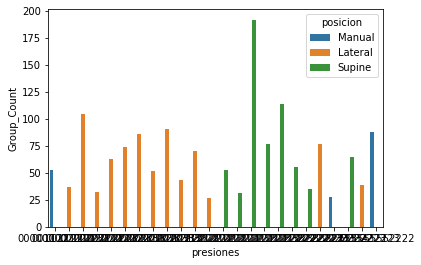

In [16]:
# Para pintarlo
grouped_df2 = perfiles_filtrado.groupby(["presiones","posicion"])
df_pres_pos_graph = pd.DataFrame(grouped_df2.size().reset_index(name = "Group_Count"))
# Elimino aquellas presiones con menos de 25 registros en hombres o mujeres
df_pres_pos_graph = df_pres_pos_graph[df_pres_pos_graph["Group_Count"]>=25]
sns.barplot(y='Group_Count',x='presiones',hue='posicion',data=df_pres_pos_graph)
plt.show()

La manera de dormir afecta totalmente a las presiones

## Cruce presiones y altura

In [22]:
### Cruce presiones y altura
# Categorizamos altura
perfiles_filtrado["altura_cat"] = pd.cut(perfiles_filtrado['altura'], bins=[0, 155, 170, 185, 250], include_lowest=True,
       labels=['<1.55', '1.5-1.7', '1.7-1.9', '>1.9'])
# Cruce
df_pres_alt = pd.DataFrame(pd.crosstab(perfiles_filtrado["presiones"],perfiles_filtrado["altura_cat"],normalize=False))



/home/dslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


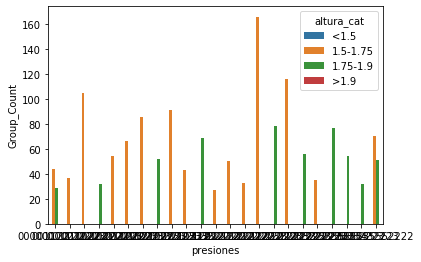

In [23]:
# Para pintarlo
grouped_df3 = perfiles_filtrado.groupby(["presiones","altura_cat"])
df_pres_alt_graph = pd.DataFrame(grouped_df3.size().reset_index(name = "Group_Count"))
# Elimino aquellas presiones con menos de 20 registros en hombres o mujeres
df_pres_alt_graph = df_pres_alt_graph[df_pres_alt_graph["Group_Count"]>=25]
sns.barplot(y='Group_Count',x='presiones',hue='altura_cat',data=df_pres_alt_graph)
plt.show()